In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, callbacks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
import pickle
import warnings
warnings.filterwarnings('ignore')

energy = pd.read_csv('./new_data/new_energy.csv') 
dangjin_fcst = pd.read_csv('./new_data/dangjin_fcst_h2320.csv')
ulsan_fcst = pd.read_csv('./new_data/ulsan_fcst_h2320.csv')

## 모델 생성 코드

* 당진태양광 : dangjin
* 당진수상태양광 : dangjin_floating
* 당진자재창고태양광 : dangjin_warehouse
* 울산태양광 : ulsan

데이터 경로 및 파일 이름 : /new_data

## 일출일몰 데이터 사용 이유

In [4]:
def get_dircat(x):
    if x < 90:
        return 1
    elif (x >= 90)&(x < 180):
        return 2
    elif (x >= 180)&(x < 270):
        return 3
    else:
        return 4    

#### <span style="color:blue">  get_dircat에 대한 설명입니다. </span> 

풍향을 방위별 4가지의 category 데이터로 변환하는 사용자 함수

In [25]:
def get_per_type(x):
    if x <= 50.0:
        return 'low'
    else:
        return 'high'  


def sun_reason(energy_dfo, fcst_dfo, target):
   
    fstart = '2016-03-02 00:00:00'
    fend = '2021-01-31 23:00:00' 
    estart = '2016-03-02 01:00:00'
    eend = '2021-02-01 00:00:00'
    
    energy_df = energy_dfo.copy()
    fcst_df = fcst_dfo.copy()
    
    energy_df[target].fillna(0, inplace=True)
    
    energy_df['time2'] = pd.to_datetime(energy_df['time'])
    fcst_df['Forecast_time2'] = pd.to_datetime(fcst_df['Forecast_time'])
    
    energy = energy_df[(energy_df['time2']>=estart)&(energy_df['time2']<=eend)]
    energy = energy.reset_index(drop=True)
    
    fcst = fcst_df[(fcst_df['Forecast_time2']>=fstart)&(fcst_df['Forecast_time2']<=fend)]
    
    fcst = fcst.reset_index(drop=True)
    
    fcst['WindDirection'] = fcst['WindDirection'].apply(get_dircat) 
    fcst['hour'] = fcst['Forecast_time2'].dt.hour
    fcst['year'] = fcst['Forecast_time2'].dt.year
    fcst['month'] = fcst['Forecast_time2'].dt.month
    fcst['per_type'] = fcst['PrecipitationProb'].apply(get_per_type) 
    
    concat_df = pd.concat([energy, fcst], axis=1)
    
    # 예보 시간, 날짜, 기상 예보 및 발전량 선택
    train_data = concat_df[['month','year','hour','sunrise', 'sunset','per_type',
                            'Precipitation','PrecipitationProb','PrecipitationForm', target]]
    
    return train_data
    

<h3>dangjin_floating 비교

In [26]:
df_df = sun_reason(energy, dangjin_fcst, target='dangjin_floating')
df_df2 = df_df[(df_df['hour']>=df_df['sunrise'])&(df_df['hour']<=df_df['sunset'])&(df_df['dangjin_floating']==0)]
ptype = df_df2['per_type'].value_counts().sort_values(ascending=False)

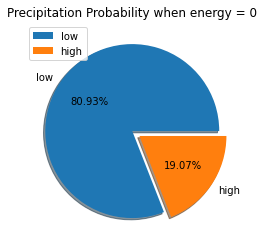

In [27]:
plt.pie(ptype.values,  autopct='%.2f%%',shadow=True, explode=(0,0.1) , labels=ptype.index)
plt.title('Precipitation Probability when energy = 0')
plt.legend(loc='upper left')
plt.show()

<h3>dangjin_warehouse 비교

In [28]:
dw_df = sun_reason(energy, dangjin_fcst, target='dangjin_warehouse')
dw_df2 = dw_df[(dw_df['hour']>=dw_df['sunrise'])&(dw_df['hour']<=dw_df['sunset'])&(dw_df['dangjin_warehouse']==0)]
ptype = dw_df2['per_type'].value_counts().sort_values(ascending=False)

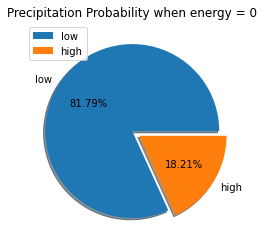

In [29]:
plt.pie(ptype.values,  autopct='%.2f%%',shadow=True, explode=(0,0.1) , labels=ptype.index)
plt.title('Precipitation Probability when energy = 0')
plt.legend(loc='upper left')
plt.show()

<h3>dangjin 비교

In [30]:
d_df = sun_reason(energy, dangjin_fcst, target='dangjin')
d_df2 = d_df[(d_df['hour']>=d_df['sunrise'])&(d_df['hour']<=d_df['sunset'])&(d_df['dangjin']==0)]
ptype = d_df2['per_type'].value_counts().sort_values(ascending=False)

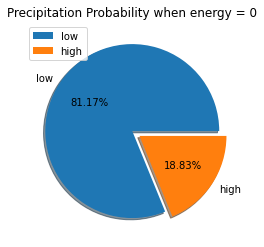

In [31]:
plt.pie(ptype.values,  autopct='%.2f%%',shadow=True, explode=(0,0.1) , labels=ptype.index)
plt.title('Precipitation Probability when energy = 0')
plt.legend(loc='upper left')
plt.show()

<h3>ulsan 비교

In [32]:
u_df = sun_reason(energy, dangjin_fcst, target='ulsan')
u_df2 = u_df[(u_df['hour']>=u_df['sunrise'])&(u_df['hour']<=u_df['sunset'])&(u_df['ulsan']==0)]
ptype = u_df2['per_type'].value_counts().sort_values(ascending=False)

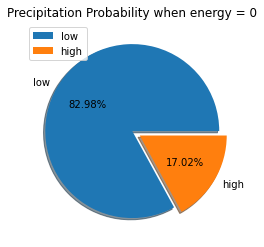

In [33]:
plt.pie(ptype.values,  autopct='%.2f%%',shadow=True, explode=(0,0.1) , labels=ptype.index)
plt.title('Precipitation Probability when energy = 0')
plt.legend(loc='upper left')
plt.show()

각 발전소 별로 주간(일출~일몰 사이의 시간)발전량이 0일 때와 강수확률을 비교 <br>

확률이 50%미만인 경우 비가 올 확률이 적다고 판단, 따라서 발전량이 0이 아니어야 함 <br>
비가 왔다면 발전량(energy)이 0인게 합리적이나 비가 오지 않음에도 발전량이 0인 구간들 다수 확인 (차트의 파란 부분)<br>
따라서 해당 구간의 데이터를 결측치로 판단, 학습을 위한 dataset을 만들 때 drop 하기로 결정하였습니다.

## feature 상관관계 분석

In [61]:
def make_correlation(energy_dfo, fcst_dfo, target):
   
    fstart = '2016-03-02 00:00:00'
    fend = '2021-01-31 23:00:00' 
    estart = '2016-03-02 01:00:00'
    eend = '2021-02-01 00:00:00'
    
    energy_df = energy_dfo.copy()
    fcst_df = fcst_dfo.copy()
    
    energy_df[target].fillna(0, inplace=True)
    
    energy_df['time2'] = pd.to_datetime(energy_df['time'])
    fcst_df['Forecast_time2'] = pd.to_datetime(fcst_df['Forecast_time'])
    
    energy = energy_df[(energy_df['time2']>=estart)&(energy_df['time2']<=eend)]
    energy = energy.reset_index(drop=True)
    
    fcst = fcst_df[(fcst_df['Forecast_time2']>=fstart)&(fcst_df['Forecast_time2']<=fend)]
    
    fcst = fcst.reset_index(drop=True)
    
    # 예보 시간 및 날짜 정보 feature로 추가
    fcst['WindDirection'] = fcst['WindDirection'].apply(get_dircat) 
    fcst['hour'] = fcst['Forecast_time2'].dt.hour
    fcst['year'] = fcst['Forecast_time2'].dt.year
    fcst['month'] = fcst['Forecast_time2'].dt.month
    fcst['day'] = fcst['Forecast_time2'].dt.day
    fcst['day_name'] = fcst['Forecast_time2'].dt.day_name()

    
    concat_df = pd.concat([energy, fcst], axis=1)
    
    # 예보 시간, 날짜, 기상 예보 및 발전량 선택
    train_data = concat_df[['month', 'day', 'day_name', 'hour', 'Temperature', 'Humidity', 
                            'WindSpeed', 'WindDirection','Cloud', 'sunrise', 'sunset',
                            'Precipitation','PrecipitationProb','PrecipitationForm',
                            target]]
 
    
    zero_idx = train_data[(train_data['hour']>=train_data['sunrise'])&(train_data['hour']<=train_data['sunset'])&(train_data[target]==0)].index 
    train_data.drop(index=zero_idx, inplace=True)
    
    train_data = train_data[['dangjin_floating','month', 'day', 'day_name', 'hour', 'Temperature', 'Humidity', 
                            'WindSpeed', 'WindDirection','Cloud', 'sunrise', 'sunset',
                             'Precipitation','PrecipitationProb','PrecipitationForm']]

    return  train_data


In [62]:
dfff = make_correlation(energy, dangjin_fcst, target='dangjin_floating')

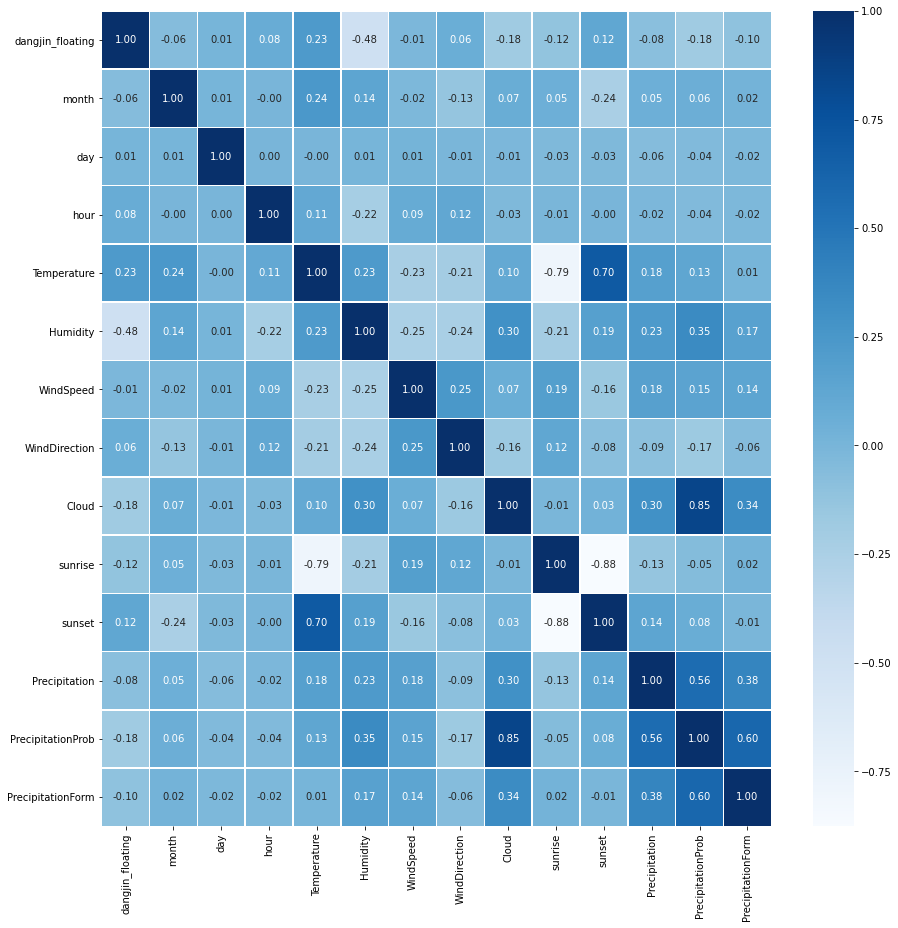

In [66]:
plt.figure(figsize=(15,15))
sns.heatmap(data = dfff.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

## <b>학습 데이터셋 생성 및 모델 학습 과정</b>

In [17]:
def sola_nmae(answer, pred):
    absolute_error = np.abs(answer - pred)
    absolute_error /= capacity
    target_idx = answer[answer>=capacity*0.1].index
    nmae = 100 * absolute_error[target_idx].mean()
    return nmae


def make_dataset(energy_dfo, fcst_dfo, target):
   
    fstart = '2016-03-02 00:00:00'
    fend = '2021-01-31 23:00:00' 
    estart = '2016-03-02 01:00:00'
    eend = '2021-02-01 00:00:00'
    
    energy_df = energy_dfo.copy()
    fcst_df = fcst_dfo.copy()
    
    energy_df[target].fillna(0, inplace=True)
    
    energy_df['time2'] = pd.to_datetime(energy_df['time'])
    fcst_df['Forecast_time2'] = pd.to_datetime(fcst_df['Forecast_time'])
    
    energy = energy_df[(energy_df['time2']>=estart)&(energy_df['time2']<=eend)]
    energy = energy.reset_index(drop=True)
    
    fcst = fcst_df[(fcst_df['Forecast_time2']>=fstart)&(fcst_df['Forecast_time2']<=fend)]
    
    fcst = fcst.reset_index(drop=True)
    
    # 예보 시간 및 날짜 정보 feature로 추가
    fcst['WindDirection'] = fcst['WindDirection'].apply(get_dircat) 
    fcst['hour'] = fcst['Forecast_time2'].dt.hour
    fcst['year'] = fcst['Forecast_time2'].dt.year
    fcst['month'] = fcst['Forecast_time2'].dt.month
    fcst['day'] = fcst['Forecast_time2'].dt.day
    fcst['day_name'] = fcst['Forecast_time2'].dt.day_name()
    fcst['PP'] = fcst['PrecipitationProb']*fcst['PrecipitationForm']
    fcst['WW'] = fcst['WindDirection']*fcst['WindSpeed'] 
    fcst['HT'] = fcst['Humidity']*fcst['Temperature']

    
    concat_df = pd.concat([energy, fcst], axis=1)
    
    # 예보 시간, 날짜, 기상 예보 및 발전량 선택
    train_data = concat_df[['month', 'day', 'day_name', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection','Cloud', 'sunrise', 'sunset',
                            'PP','WW','HT', target]]
 
    
    zero_idx = train_data[(train_data['hour']>=train_data['sunrise'])&(train_data['hour']<=train_data['sunset'])&(train_data[target]==0)].index 
    train_data.drop(index=zero_idx, inplace=True)
    
    train_set = train_data[['month', 'day','day_name', 'hour','Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud', 'PP','WW','HT']]
        
    train_set = pd.get_dummies(train_set, columns = ['hour','WindDirection', 'day_name']) #카데고리형 데이터 원핫 인코딩 
    
    target_set = train_data[target]
    return train_test_split(train_set, target_set, test_size=0.08, shuffle=False, random_state=0)


early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', patience=20,    
    min_delta=0.001, 
    restore_best_weights=True,
)

try:
    with open('models/models.pickle', 'rb') as fd:
        models = pickle.load(fd)
except:
    print('no file')

num_loop = 5

위 코드의 num_loop = 5은 훈련 횟수를 지정하는 부분입니다. <br>
5번 동안 가중치가 변환되며 모델이 저장됩니다.

### <span style="color:red"><b>[초기화 코드]</b></span> 
#### <span style="color:blue">* 아래 셀은 score 초기화시 code로 변경 후 한번 실행하고 다시 markdown으로 변경하면 됩니다. </span> 

with open('models/models.pickle', 'rb') as fd:
        models = pickle.load(fd)
        
models['df']['cv'] = 20.0
models['dw']['cv'] = 20.0
models['d']['cv'] = 20.0
models['u']['cv'] = 20.0
models['df']['history']=0
models['dw']['history']=0
models['d']['history']=0
models['u']['history']=0

with open('models/models.pickle','wb') as fd:
    pickle.dump(models,fd)

#### <span style="color:green"> [ 모델을 결정하기 위한 과정 설명입니다. ] </span> 

데이터 정규화를 위하여 BatchNormalization층을 데이터 정렬 후와 Dense층 이후에 추가하였다.<br>
과적합을 피하기 위해 BatchNormalization층 이후에 Dropout층을 추가하였다.<br>
RandomizedSearchCV를 이용하여 optimizer는 SGD로, batch_size는 64로 설정하였다.<br>
또한 Dropout확률, 학습률, Dense층의 노드 수를 결정한 후 결과 기반으로 미세 조정하였다.<br>
early_stopping 콜백함수를 이용하여 과적합을 방지하고 최적의 모델을 저장하였다. <br>

아래의 이미지는 RandomizedSearchCV 사용 결과입니다.


![title](img/코드캡쳐.png)
![title](img/코드결과.png)

## dangjin_floating

In [18]:
lr = 0.003
capacity = 1000

train_x, val_x, train_y, val_y = make_dataset(energy, dangjin_fcst, target='dangjin_floating')
train_x = train_x.reset_index(drop=True)
train_y = train_y.reset_index(drop=True)
val_x = val_x.reset_index(drop=True)
val_y = val_y.reset_index(drop=True)
print(val_x.shape)

for i in range(num_loop):
    dangjin_floating_model = keras.Sequential([
        keras.layers.Flatten(input_shape=(train_x.shape[1],)),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dense(1)
    ])

    dangjin_floating_model.compile(optimizer=SGD(learning_rate=lr),
                  loss='mae',
                  metrics=['mae'])

    history = dangjin_floating_model.fit(train_x, train_y, callbacks=early_stopping, verbose=0, validation_data=(val_x, val_y), epochs=300, batch_size=64)

    pred = dangjin_floating_model.predict(val_x)
    pred = pred.flatten()
    nmae1 = sola_nmae(val_y, pred)

    if nmae1 < models['df']['cv']:
        print('pre : {} -> curr : {}'.format(models['df']['cv'], nmae1))
        models['df']['cv'] = nmae1
        dangjin_floating_model.save('models/dangjin_floating_model.h5')
    else:
        print('not changed')

(3274, 44)
pre : 20.0 -> curr : 7.416097991137326
not changed
not changed
not changed
pre : 7.416097991137326 -> curr : 7.273808102827191


## dangjin_warehouse

In [19]:
lr = 0.002
capacity = 700

train_x, val_x, train_y, val_y = make_dataset(energy, dangjin_fcst, target='dangjin_warehouse')
train_x = train_x.reset_index(drop=True)
train_y = train_y.reset_index(drop=True)
val_x = val_x.reset_index(drop=True)
val_y = val_y.reset_index(drop=True)

for i in range(num_loop):
    dangjin_warehouse_model = keras.Sequential([
        keras.layers.Flatten(input_shape=(train_x.shape[1],)),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dense(1)
    ])

    dangjin_warehouse_model.compile(optimizer=SGD(learning_rate=lr),
                  loss='mae',
                  metrics=['mae'])

    history = dangjin_warehouse_model.fit(train_x, train_y, callbacks=early_stopping, verbose=0, validation_data=(val_x, val_y), epochs=300, batch_size=64)

    pred = dangjin_warehouse_model.predict(val_x)
    pred = pred.flatten()
    nmae2 = sola_nmae(val_y, pred)

    if nmae2 < models['dw']['cv']:
        print('pre : {} -> curr : {}'.format(models['dw']['cv'], nmae2))
        models['dw']['cv'] = nmae2
        dangjin_warehouse_model.save('models/dangjin_warehouse_model.h5')
    else:
        print('not changed')

pre : 20.0 -> curr : 8.767685214088443
not changed
not changed
not changed
not changed


## dangjin

In [20]:
lr = 0.002
capacity = 1000

train_x, val_x, train_y, val_y = make_dataset(energy, dangjin_fcst, target='dangjin')
train_x = train_x.reset_index(drop=True)
train_y = train_y.reset_index(drop=True)
val_x = val_x.reset_index(drop=True)
val_y = val_y.reset_index(drop=True)


for i in range(num_loop):
    dangjin_model = keras.Sequential([
        keras.layers.Flatten(input_shape=(train_x.shape[1],)),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dense(1)
    ])

    dangjin_model.compile(optimizer=SGD(learning_rate=lr),
                  loss='mae',
                  metrics=['mae'])

    history = dangjin_model.fit(train_x, train_y, callbacks=early_stopping, verbose=0, validation_data=(val_x, val_y), epochs=300, batch_size=64)

    pred = dangjin_model.predict(val_x)
    pred = pred.flatten()
    nmae3 = sola_nmae(val_y, pred)

    if nmae3 < models['d']['cv']:
        print('pre : {} -> curr : {}'.format(models['d']['cv'], nmae3))
        models['d']['cv'] = nmae3
        dangjin_model.save('models/dangjin_model.h5')
    else:
        print('not changed')

pre : 20.0 -> curr : 9.379795873237967
not changed
pre : 9.379795873237967 -> curr : 9.221419158244085
not changed
not changed


## ulsan

In [21]:
lr = 0.002
capacity = 500

train_x, val_x, train_y, val_y = make_dataset(energy, ulsan_fcst, target='ulsan')
train_x = train_x.reset_index(drop=True)
train_y = train_y.reset_index(drop=True)
val_x = val_x.reset_index(drop=True)
val_y = val_y.reset_index(drop=True)
print(val_x.shape)

for i in range(num_loop):
    ulsan_model = keras.Sequential([
        keras.layers.Flatten(input_shape=(train_x.shape[1],)),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dense(1)
    ])

    ulsan_model.compile(optimizer=SGD(learning_rate=lr),
                  loss='mae',
                  metrics=['mae'])

    history = ulsan_model.fit(train_x, train_y, callbacks=early_stopping, verbose=0, validation_data=(val_x, val_y), epochs=300, batch_size=64)

    pred = ulsan_model.predict(val_x)
    pred = pred.flatten()
    nmae4 = sola_nmae(val_y, pred)

    if nmae4 < models['u']['cv']:
        print('pre : {} -> curr : {}'.format(models['u']['cv'], nmae4))
        models['u']['cv'] = nmae4
        ulsan_model.save('models/ulsan_model.h5')
    else:
        print('not changed')

(3185, 44)
pre : 20.0 -> curr : 7.659872660806527
pre : 7.659872660806527 -> curr : 7.203927050395445
not changed
not changed
pre : 7.203927050395445 -> curr : 7.198515227283885


In [22]:
models

{'df': {'cv': 7.273808102827191, 'history': 0},
 'dw': {'cv': 8.767685214088443, 'history': 0},
 'd': {'cv': 9.221419158244085, 'history': 0},
 'u': {'cv': 7.198515227283885, 'history': 0}}

In [23]:
print('current nmae score =',(models['df']['cv']+models['dw']['cv']+models['d']['cv']+models['u']['cv'])/4)

current nmae score = 8.1153569256109


In [24]:
with open('models/models.pickle','wb') as fd:
    pickle.dump(models,fd)